## Custom Model Training for Emotion, Age, and Gender Classification

The purpose of this notebook is to perform custom training of three binary classification models using TensorFlow and Keras.

*  **Emotion model**: This model is used to classify between happy vs sad. It is trained on a subset of the FER-2013 dataset, using only the happy and sad classes. It uses a custom CNN model with greyscale 48x48 images. It is designed to be compact for later deployment for mobile/web environments.
* **Age model**: This model is designed for binary classification between adults and elderly. It is trained on the UTKFace dataset with (age < 50 → Adult, ≥ 50 → Elderly). It uses  a MobileNetV2-based binary classifier on resized 224×224 RGB images.
*   **Gender model:** This model is designed for binary classification between male and female. It is trained on the UTKFace dataset, using using MobileNetV2 in the same way as the age model.
*   The trained models will be saved as .h5 files, and will be converted to TF.js or TFLite in the next phase.


**1. Setting up the environment**

In [ ]:
!pip install -q tensorflow opendatasets scikit-learn pandas matplotlib

In [19]:
import os
import cv2
import numpy as np
import pandas as pd
from IPython.display import display
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

In [10]:
import kagglehub

# Download latest version FER-2013
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [ ]:
!ls /kaggle/input/fer2013/


test  train


In [11]:
# Download latest version UTKFace
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/utkface-new


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Define paths
DRIVE_PATH = "/content/drive/MyDrive/Edge_AI_Project"
MODEL_PATH = os.path.join(DRIVE_PATH, "models/saved_models")
LOG_PATH = os.path.join(DRIVE_PATH, "models/logs")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)
utkface_dir = "/kaggle/input/utkface-new/UTKFace"
emotion_train_dir = "/kaggle/input/fer2013/train"
emotion_test_dir = "/kaggle/input/fer2013/test"

**2. Training the models**

The training function has been designed to find a balance between accuracy and avoiding RAM usage crashes.
We will use a low batch size of 8. The models are trained using 10 epochs. This increases training time, but does increase accuray with minimal impact on RAM usage.
The trained models for age, gender and emotion will be saved with performance metrics logged.
After training each model, the session will be cleared before the next model is trained.

In [21]:
# Load UTKFace subset
def load_utkface_subset(data_dir, task='age', max_samples=2000):
    data = []
    count = 0
    for file in os.listdir(data_dir):
        if file.endswith('.jpg'):
            parts = file.split('_')
            if len(parts) < 2: continue
            age = int(parts[0])
            gender = int(parts[1])
            img = cv2.imread(os.path.join(data_dir, file))
            if img is None: continue
            img = cv2.resize(img, (224, 224))
            label = 0 if (task == 'age' and age < 50) else 1 if task == 'age' else gender
            data.append((img, label))
            count += 1
            if count >= max_samples: break
    X, y = zip(*data)
    return np.array(X).astype('float32') / 255.0, np.array(y)

def prepare_data(X, y):
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def build_mobilenet_classifier():
    base = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base.input, outputs=x)

In [33]:
# Setting up the training and logging function
def train_and_log(model, X_train, y_train, X_val, y_val, name, epochs=10):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=8)
    model.save(os.path.join(MODEL_PATH, f"{name}.h5"))
    print(f"✅ Saved {name}.h5")
    hist_df = pd.DataFrame(history.history)
    hist_df.index.name = 'epoch'
    hist_df.to_csv(os.path.join(LOG_PATH, f"{name}_log.csv"))
    K.clear_session()

**3. Training the Emotion model**

The emotion model is designed for binary classification between happy and sad. The original FER2013 dataset contains data for 7 emotions, but we will use only the "happy" and "sad" subfolders to train the model.

In [24]:
# Build emotion model
def build_emotion_model():
    inputs = Input(shape=(48, 48, 1))
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, x)

In [27]:
import os
import shutil

# Source paths
source_train = "/kaggle/input/fer2013/train"
source_test = "/kaggle/input/fer2013/test"

# Target paths
target_train = "/content/emotion_binary/train"
target_test = "/content/emotion_binary/test"

# Emotion folders to keep
target_classes = ['happy', 'sad']

for cls in target_classes:
    os.makedirs(os.path.join(target_train, cls), exist_ok=True)
    os.makedirs(os.path.join(target_test, cls), exist_ok=True)

    # Copy training images
    src_cls_train = os.path.join(source_train, cls)
    tgt_cls_train = os.path.join(target_train, cls)
    for fname in os.listdir(src_cls_train):
        shutil.copy(os.path.join(src_cls_train, fname), os.path.join(tgt_cls_train, fname))

    # Copy test images
    src_cls_test = os.path.join(source_test, cls)
    tgt_cls_test = os.path.join(target_test, cls)
    for fname in os.listdir(src_cls_test):
        shutil.copy(os.path.join(src_cls_test, fname), os.path.join(tgt_cls_test, fname))

print("✅ Filtered dataset created at /content/emotion_binary")

✅ Filtered dataset created at /content/emotion_binary


In [29]:
emotion_train_dir = "/content/emotion_binary/train"
emotion_test_dir = "/content/emotion_binary/test"

In [32]:
# Train Emotion Model
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(emotion_train_dir, target_size=(48, 48),
    color_mode='grayscale', class_mode='binary', batch_size=8, shuffle=True)
test_generator = datagen.flow_from_directory(emotion_test_dir, target_size=(48, 48),
    color_mode='grayscale', class_mode='binary', batch_size=8, shuffle=False)

model = build_emotion_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=test_generator, epochs=10)
model.save(os.path.join(MODEL_PATH, 'emotion_model.h5'))
K.clear_session()

Found 12045 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1506/1506 ━━━━━━━━━━━━━━━━━━━━ 185s 121ms/step - accuracy: 0.6596 - loss: 0.8519 - val_accuracy: 0.7193 - val_loss: 0.4927
Epoch 2/10
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 192s 128ms/step - accuracy: 0.7879 - loss: 0.4199 - val_accuracy: 0.7494 - val_loss: 0.4616
Epoch 3/10
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 181s 120ms/step - accuracy: 0.8188 - loss: 0.3810 - val_accuracy: 0.7795 - val_loss: 0.4401
Epoch 4/10
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 200s 133ms/step - accuracy: 0.8354 - loss: 0.3341 - val_accuracy: 0.7997 - val_loss: 0.4214
Epoch 5/10
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 195s 130ms/step - accuracy: 0.8611 - loss: 0.2762 - val_accuracy: 0.7881 - val_loss: 0.4426
Epoch 6/10
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 183s 122ms/step - accuracy: 0.8705 - loss: 0.2600 - val_accuracy: 0.7901 - val_loss: 0.5135
Epoch 7/10
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 208s 138ms/step - accuracy: 0.8732 - loss: 0.2432 - val_accuracy: 0.8024 - val_loss: 0.4627
Epoch 8/10
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 243s 125ms/step - accuracy: 0.9

**4. Training the age and gender models**

In [34]:
# Train Age Model
X_age, y_age = load_utkface_subset(utkface_dir, task='age')
X_train, X_val, y_train, y_val = prepare_data(X_age, y_age)
model = build_mobilenet_classifier()
train_and_log(model, X_train, y_train, X_val, y_val, name='age_model')
K.clear_session()

# Train Gender Model
X_gender, y_gender = load_utkface_subset(utkface_dir, task='gender')
X_train, X_val, y_train, y_val = prepare_data(X_gender, y_gender)
model = build_mobilenet_classifier()
train_and_log(model, X_train, y_train, X_val, y_val, name='gender_model')
K.clear_session()

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.7939 - loss: 0.5499 - val_accuracy: 0.7775 - val_loss: 2.9145
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.8643 - loss: 0.3362 - val_accuracy: 0.7775 - val_loss: 2.6603
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.8882 - loss: 0.2819 - val_accuracy: 0.7775 - val_loss: 2.5746
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.8906 - loss: 0.2641 - val_accuracy: 0.7800 - val_loss: 1.3648
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.9117 - loss: 0.2323 - val_accuracy: 0.4575 - val_loss: 1.2652
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.9081 - loss: 0.2095 - val_accuracy: 0.7775 - val_loss: 3.1950
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.9454 - loss: 0.1489 - val_accuracy: 0.8075 - val_loss: 1.1662
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9405 - loss: 0.1589 - val_accu

✅ Saved age_model.h5
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.6608 - loss: 0.7265 - val_accuracy: 0.4875 - val_loss: 5.5473
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.8463 - loss: 0.3829 - val_accuracy: 0.5425 - val_loss: 2.5502
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.8604 - loss: 0.3131 - val_accuracy: 0.7375 - val_loss: 0.6653
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.8955 - loss: 0.2429 - val_accuracy: 0.6650 - val_loss: 1.2820
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.9302 - loss: 0.1806 - val_accuracy: 0.6425 - val_loss: 1.1347
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.9050 - loss: 0.2150 - val_accuracy: 0.4950 - val_loss: 6.0999
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.9172 - loss: 0.2236 - val_accuracy: 0.6025 - val_loss: 1.5229
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.9645 - lo

✅ Saved gender_model.h5


**5. Performance metrics**

In [38]:
# Save emotion history manually (if still in memory)
hist_df = pd.DataFrame(model.history.history)
hist_df.index.name = 'epoch'
hist_df.to_csv(os.path.join(LOG_PATH, "emotion_model_log.csv"))
print("✅ Saved emotion_model_log.csv")


✅ Saved emotion_model_log.csv


In [39]:
# Print final performance summary table
summary = []

for name in ["age_model", "gender_model", "emotion_model"]:
    log_path = os.path.join(LOG_PATH, f"{name}_log.csv")
    if os.path.exists(log_path):
        df = pd.read_csv(log_path)
        final_row = df.iloc[-1]
        summary.append({
            "Model": name.replace("_model", "").capitalize(),
            "Val Accuracy": round(final_row['val_accuracy'], 4),
            "Val Loss": round(final_row['val_loss'], 4)
        })

summary_df = pd.DataFrame(summary)
display(summary_df)

,Model,Val Accuracy,Val Loss
0,Age,0.7975,2.7704
1,Gender,0.5050,3.9126
2,Emotion,0.5050,3.9126


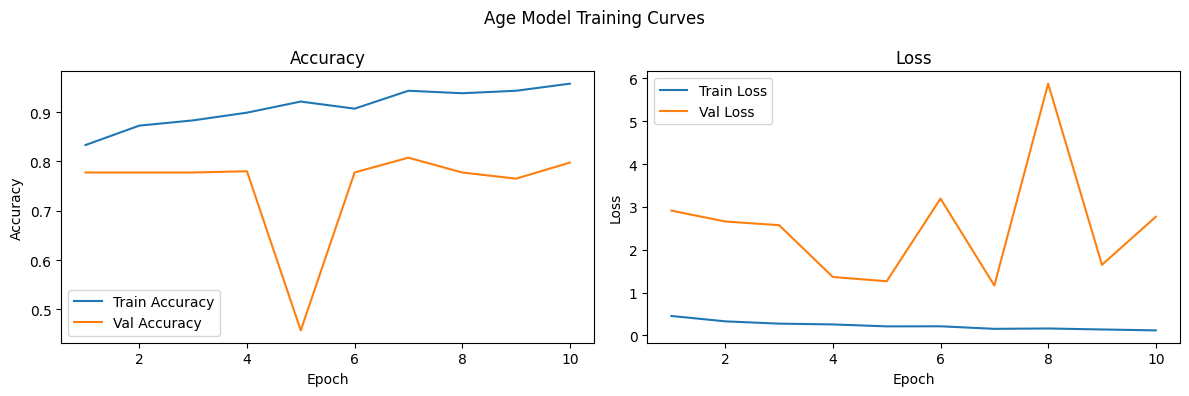

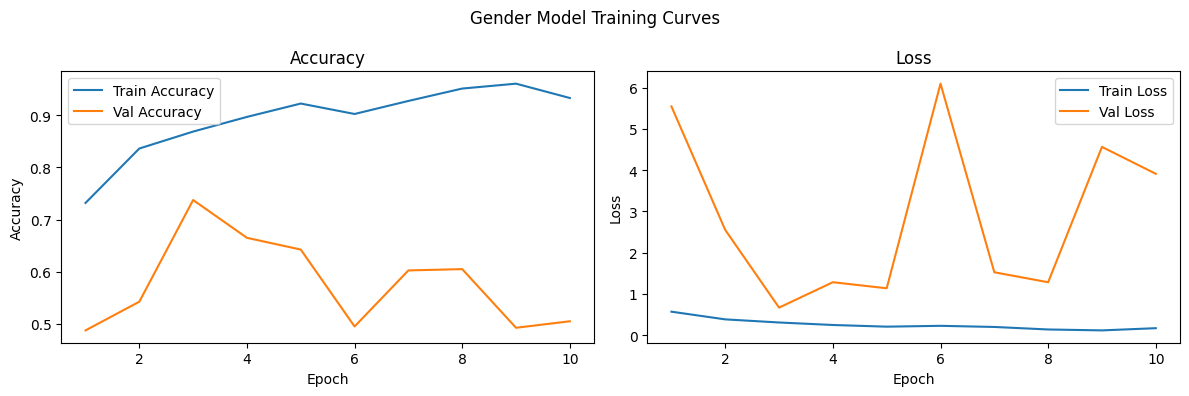

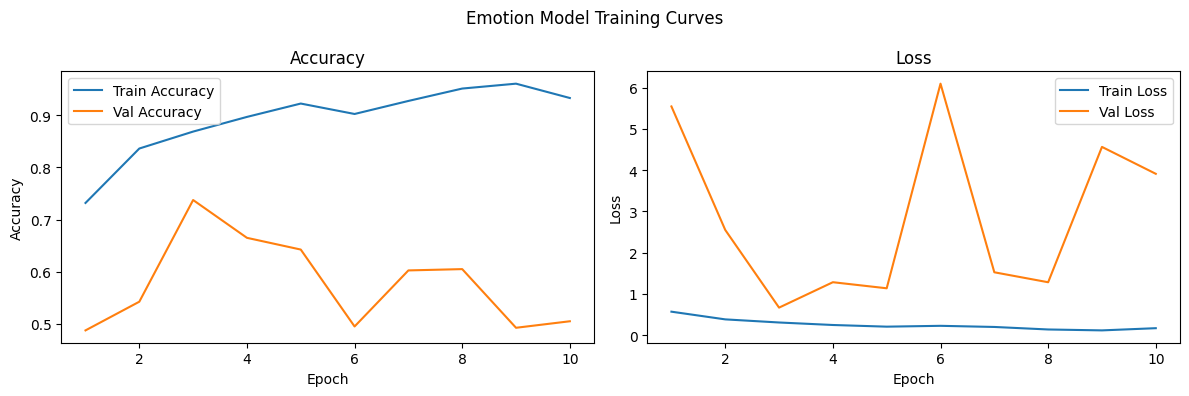

In [41]:
# Cell 12: Plot training and validation curves
import matplotlib.pyplot as plt

def plot_history(log_path, title):
    if not os.path.exists(log_path):
        print(f"❌ Log not found for {title}")
        return
    df = pd.read_csv(log_path)
    epochs = df.index + 1

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{title} Model Training Curves')

    ax[0].plot(epochs, df['accuracy'], label='Train Accuracy')
    ax[0].plot(epochs, df['val_accuracy'], label='Val Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(epochs, df['loss'], label='Train Loss')
    ax[1].plot(epochs, df['val_loss'], label='Val Loss')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Plot for each model
for name in ["age_model", "gender_model", "emotion_model"]:
    plot_history(os.path.join(LOG_PATH, f"{name}_log.csv"), name.replace("_model", "").capitalize())
